In [3]:
# 最基本的RNN模型

In [11]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date','prediction'], axis=1)
# print(dataset.columns)
# print(dataset.tail())
dataset['future'] = dataset['future']
print(dataset.shape)
# print(dataset.tail())

# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
SEQ_LEN = 60
BATCH_SIZE = 1                                                    # 注意：BATCH_SIZE是要能够整除seq_count的
TEST_BATCH_COUNT = 5

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LEN):
    if i.shape[0] == SEQ_LEN:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LEN, dataset.shape[1])                 # 数据一共是 seq_count x seq_len x (in_dim+1)

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LEN))


total_batch_count = int(rolling_data.shape[0]/BATCH_SIZE)                                   # 把数据规划成 batch_count 个 batch

print("total batch count: {}".format(total_batch_count))
print("batch size: {}".format(BATCH_SIZE))

rolling_data = rolling_data.reshape(total_batch_count, BATCH_SIZE, SEQ_LEN, dataset.shape[1])  # 把数据转成 total_batch_count x BATCH_SIZE x seq_len x in_dim 格式
rolling_data = torch.tensor(rolling_data)
print("rolling_data: {}".format(rolling_data.shape))


train_batch_count = total_batch_count - TEST_BATCH_COUNT
test_batch_count = TEST_BATCH_COUNT

train = rolling_data[:train_batch_count, :, :, :]
test  = rolling_data[train_batch_count:, :, :, :]

train_x, train_y = train[:,:,:,1:], train[:,:,:,0:1]
test_x,  test_y  = test[:,:,:, 1:],  test[:,:,:,0:1]

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train_batch_count))
print("test_batch_count:  {}".format(test_batch_count))

(500, 123)
rolling_data shape: (441, 60, 123)
seq count: 441
seq length: 60
total batch count: 441
batch size: 1
rolling_data: torch.Size([441, 1, 60, 123])
train_x: torch.Size([436, 1, 60, 122])
train_y: torch.Size([436, 1, 60, 1])
test_x:  torch.Size([5, 1, 60, 122])
test_y:  torch.Size([5, 1, 60, 1])
train_batch_count: 436
test_batch_count:  5


In [12]:
# 定义 RNN 模型
np.random.seed(1027)
torch.manual_seed(1027)
torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

# 开始定义 RNN 模型
TIME_STEP = SEQ_LEN                                        # 一般这个单独设定，这里为了简单，还是直接就等于seq_len的方便。其实也就是等于最长的那个sequence length
INPUT_SIZE = dataset.shape[1]-1
HIDDEN_SIZE = 1024
NUM_LAYERS = 6

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.dropout = nn.Dropout(p=0.1)
        
        self.rnn = nn.RNN(
                input_size = INPUT_SIZE,                    # 输入 x 的feature 维度
                hidden_size = HIDDEN_SIZE,                  # 隐状态 hidden_state 中的feature维度
                num_layers = NUM_LAYERS,                    # RNN 的层数
                nonlinearity='relu',                        # 指定激活函数 [‘tanh’ | ’relu’]. 默认: ‘tanh’
                bias = True,                                # 如果是 False , 那么 RNN 层就不会使用偏置权重 b_ih 和 b_hh, 默认: True
                batch_first = True,                         # 如果 True, 输入Tensor的shape应该是(BATCH_SIZE, seq_len, features),并且输出也是一样.
                dropout = 0.1,                              # 如果值非零, 那么除了最后一层外, 其它层的输出都会套上一个 dropout 层
                bidirectional = False                       # 如果 True , 将会变成一个双向 RNN, 默认为 False
        )
        
        self.out = nn.Linear(HIDDEN_SIZE, 1)
                
        # weight的参数用kaiming初始化；bias用zeros初始化；
        # for name, param in self.rnn.named_parameters():
        #     if name.startswith("weight"):
        #         nn.init.kaiming_normal_(param, nonlinearity='relu')
        #     else:
        #         nn.init.zeros_(param)

        # weight的参数用xavier初始化；bias用zeros初始化；
        # for name, param in self.rnn.named_parameters():
        #     if name.startswith("weight"):
        #         nn.init.xavier_normal_(param)
        #     else:
        #         nn.init.zeros_(param)
        
    def forward(self, x):
        x = self.dropout(x)
        
        h_state = torch.zeros(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE).double().to(device)             
        r_out, h_state = self.rnn(x, h_state)                                                      # compute from [1, seq_len, input_dim] to [1, seq_len, hidden_dim] 
        
        # r_out = self.dropout(r_out)
        
        outs = []
        for time_step in range(TIME_STEP):
            out = self.out(r_out[:, time_step, :])                                                 # compute from [1, 1, hidden_dim] to [output_dim]
            outs.append(out)                                                                       # Add all seq_len data to list like : [[pred1, pred2,...,predn]] 
        return torch.stack(outs, dim=1), h_state                                                   # conver from [[pred1,...,predn]] to [[[pred1], ... ,[prdn]]]

In [13]:
# 训练 RNN 模型 ---- 这里的损失函数是计算Sequence全部元素的预测数据和真实数据差异
# model = RNN().double().to(device)
# LR = 1e-4
# loss_func = nn.MSELoss(reduction="mean")
# optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1)

# # 计划训练 20 轮
# epoch = 0
# epochs = 20
# epoch_loss = 0
# epoch_loss_list=[]
# for epoch in range(epochs):
#     for step in range(train_batch_count):
#         pred, h_state = model(train_x[step])                      # 其实这里的h_state也可以带给下一个batch作为输入。例如 pred,h_state=model(train_x[step], h_state)  h_state=h_state.data
#         loss = loss_func(pred, train_y[step])
#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
#         optimizer.step()
        
#         epoch_loss += loss.data

#     print("{} of {} epochs get epoch_loss: {:.6f}".format(epoch, epochs, epoch_loss))
#     epoch_loss_list.append(epoch_loss)
#     epoch_loss = 0
#     # scheduler.step()

# plt.plot(epoch_loss_list)
# plt.show()

In [14]:
# 保存模型
# torch.save(model, 'e:\\Model_RNN.pkl')

In [15]:
# 加载模型
# model = torch.load('e:\\Model_RNN.pkl')

In [16]:
# 用模型来做测试数据的预测 ---- 这里的预测的是全部LSTM数据

# for step in range(test_batch_count):
#     pred, h_state = model(test_x[step])
#     loss = loss_func(pred, test_y[step])

#     print("Prediction: {:.2f} ---- Actual: {:.2f}".format(float(pred[-1][-1].data), float(test_y[step][-1][-1].data)))
#     print("loss : {:.6f}".format(float(loss.data)))

#     # print(test_y[step][-1].flatten().shape)
#     # print(pred[-1].flatten().shape)
    
#     # actual_line = test_y[step][-1].cpu().detach().flatten().numpy()
#     # pred_line   = pred[-1].cpu().detach().flatten().numpy()
    
#     actual_line = test_y[step].cpu().detach().flatten().numpy()
#     pred_line   = pred.cpu().detach().flatten().numpy()
    
#     plt.plot(actual_line, 'r--')
#     plt.plot(pred_line, 'b-')
#     plt.show()

0 of 200 epochs get epoch_loss: 3.811980
1 of 200 epochs get epoch_loss: 3.782995
2 of 200 epochs get epoch_loss: 3.727335
3 of 200 epochs get epoch_loss: 3.589459
4 of 200 epochs get epoch_loss: 3.504692
5 of 200 epochs get epoch_loss: 3.483803
6 of 200 epochs get epoch_loss: 3.560177
7 of 200 epochs get epoch_loss: 3.602457
8 of 200 epochs get epoch_loss: 3.621892
9 of 200 epochs get epoch_loss: 3.606869
10 of 200 epochs get epoch_loss: 3.596067
11 of 200 epochs get epoch_loss: 3.582497
12 of 200 epochs get epoch_loss: 3.563832
13 of 200 epochs get epoch_loss: 3.567557
14 of 200 epochs get epoch_loss: 3.489532
15 of 200 epochs get epoch_loss: 3.487180
16 of 200 epochs get epoch_loss: 3.470139
17 of 200 epochs get epoch_loss: 3.463137
18 of 200 epochs get epoch_loss: 3.570785
19 of 200 epochs get epoch_loss: 3.540101
20 of 200 epochs get epoch_loss: 3.349596
21 of 200 epochs get epoch_loss: 3.256454
22 of 200 epochs get epoch_loss: 3.414660
23 of 200 epochs get epoch_loss: 3.404852
24

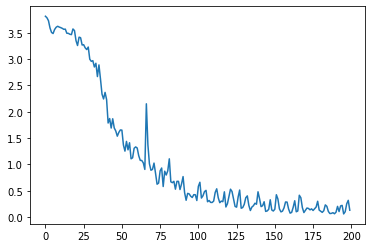

In [17]:
# 训练 RNN 模型 ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model = RNN().double().to(device)
LR = 1e-4
loss_func = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1)

# 计划训练 20 轮
epoch = 0
epochs = 200
epoch_loss = 0
epoch_loss_list=[]
for epoch in range(epochs):
    for step in range(train_batch_count):
        pred, h_state = model(train_x[step])                      # 其实这里的h_state也可以带给下一个batch作为输入。例如 pred,h_state=model(train_x[step], h_state)  h_state=h_state.data
        loss = loss_func(pred[-1][-1], train_y[step][-1][-1])
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        
        epoch_loss += loss.data.cpu()

    print("{} of {} epochs get epoch_loss: {:.6f}".format(epoch, epochs, epoch_loss))
    epoch_loss_list.append(epoch_loss)
    epoch_loss = 0
    # scheduler.step()

plt.plot(epoch_loss_list)
plt.show()

In [23]:
# 保存模型
torch.save(model, 'e:\\Model_RNN.pkl')

In [24]:
# 加载模型
model = torch.load('e:\\Model_RNN.pkl')

Prediction Loss average:0.013730
Prediction: -0.05 ---- Actual: 0.00


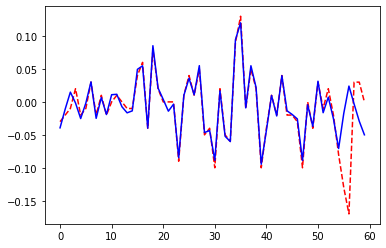

In [25]:
# 预测数据
model.eval()

test_loss = 0

for step in range(test_batch_count):
    pred, h_state = model(test_x[step])

    loss = loss_func(pred[-1][-1], test_y[step][-1][-1])

    # print("Prediction: {:.2f} ---- Actual: {:.2f}".format(float(pred[-1][-1].data), float(test_y[step][-1][-1].data)))
    
    if (step+1) < test_batch_count:                       # 最后一个测试数据不需要统计，因为没有真实值。
        test_loss += loss.cpu()
    
print("Prediction Loss average:{:.6f}".format(test_loss.data/(test_batch_count-1)))
print("Prediction: {:.2f} ---- Actual: {:.2f}".format(float(pred[-1][-1].data), float(test_y[step][-1][-1].data)))

actual_line = test_y[step].cpu().detach().flatten().numpy()
pred_line   = pred.cpu().detach().flatten().numpy()
plt.plot(actual_line, 'r--')
plt.plot(pred_line, 'b-')
plt.show()